In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

# test_sample_ratio = 0.40

run_tables = False

Welcome to JupyROOT 6.22/06
{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Event selection

In [3]:
def select_events( df_events ):
#     label_jet_ = "_nom"
#     label_muon_ = "_nom"
#     label_WLep_ = "_nom"
#     label_WW_ = "_nom"
    label_jet_ = "_jes_up"
    label_muon_ = "_nom"
    label_WLep_ = "_nom"
    label_WW_ = "_jes_up"
    
    df_events.loc[ :, "deltaPhi_jet_muon"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "muon0_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaEta_jet_muon"] = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, "muon0_eta"] )
    df_events.loc[ :, "deltaR_jet_muon"] = np.sqrt( ( df_events.loc[ :, "deltaPhi_jet_muon"] ) ** 2 +
                                                    ( df_events.loc[ :, "deltaEta_jet_muon"] ) ** 2 )
    
    df_events.loc[ :, "deltaPhi_jet_met"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaPhi_jet_Wlep"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] - 2*np.pi

    df_events.loc[ :, "jet0_tau21" ] = df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"]
    
    df_events.loc[ :, "xiCMS_45" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] * np.exp( df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" + label_jet_ ] * np.exp( df_events.loc[ :, "jet0_eta" ] ) )
    df_events.loc[ :, "xiCMS_56" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] * np.exp( -df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" + label_jet_ ] * np.exp( -df_events.loc[ :, "jet0_eta" ] ) )

    df_events.loc[ :, "R_MWW_MX" + label_WW_ ] = ( df_events.loc[ :, "MWW" + label_WW_ ] / df_events.loc[ :, "MX" ] )
    df_events.loc[ :, "Diff_YWW_YX" + label_WW_ ] = ( df_events.loc[ :, "YWW" + label_WW_ ] - df_events.loc[ :, "YX" ] )
    
    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    msk_muon_ = ( ( df_events.loc[ :, "muon0_pt" + label_muon_ ] >= 50.0 ) &
                  ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                  ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt" + label_jet_] >= 200.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_muon_ = ( df_events.loc[ :, "deltaR_jet_muon"] >= np.pi/2 )
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    msk_jet_met_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_met"] ) >= 2.0 )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass" + label_jet_] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass" + label_jet_] <= 110.0 ) )
    msk_tau21_       = ( df_events.loc[ :, "jet0_tau21"] <= 0.60 )
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" ] <= 0.20 ) )
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt" + label_WLep_ ] >= 200.0 )
    msk_jet_Wlep_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_Wlep"] ) >= 2.5 )
#     msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_MWW_ = ( df_events.loc[ :, "MWW" + label_WW_ ] >= 500.0 )
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 4 )
#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )
    
    masks_ = [ msk_All_, msk_muon_, msk_jet_, msk_jet_muon_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    selection_keys_ = [ "All", "Muon", "Jet", "Jet_Muon", "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [4]:
#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/07 20:22:30
Total time elapsed: 1
2021/05/07 20:22:31
Total time elapsed: 1
2021/05/07 20:22:32
Total time elapsed: 4


In [5]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index[ label_ ]
df_signals_protons_multiRP_index[ label_ ][ [ 'run_mc', 'crossingAngle', 'period', 'within_aperture' ] ]

run_mc  crossingAngle  period  within_aperture
run lumiblock event  slice                                                
1   2266      226549 0      302030          120.0   2017D             True
              226551 0      305965          120.0  2017F3             True
                     0      305965          120.0  2017F3             True
    2267      226605 0      305178          120.0  2017F2             True
              226690 0      299337          120.0  2017C1             True
    2268      226716 0      305178          150.0  2017F2             True
              226773 0      303435          150.0   2017E             True
    2270      226932 0      297020          130.0   2017B             True
                     0      297020          130.0   2017B             True
    2273      227227 0      305178          130.0  2017F2             True
                     0      305178          130.0  2017F2             True
    2274      227321 0      299337          150.0  2017C1             True
              227328 0      299337          150.0  2017C1             True
              227324 0      303435          150.0   2017E             True
    2275      227457 0      303435          150.0   2017E             True
                     0      303435          150.0   2017E             True
    2276      227546 0      300806          140.0  2017C2             True
                     0      300806          140.0  2017C2             True
              227579 0      303435          140.0   2017E             True
                     0      303435          140.0   2017E             True
    2277      227611 0      299337          130.0  2017C1             True
              227610 0      300806          130.0  2017C2             True
              227661 0      302030          130.0   2017D             True
    2278      227745 0      303435          150.0   2017E             True
    2279      227825 0      299337          130.0  2017C1             True
              227868 0      303435          130.0   2017E             True
    2280      227969 0      303435          120.0   2017E             True
    2282      228117 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
              228121 0      299337          130.0  2017C1             True
...                            ...            ...     ...              ...
    9019      401833 0      303435          130.0   2017E             True
              401874 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
    9021      402066 0      303435          119.0   2017E             True
                     0      303435          119.0   2017E             True
              402070 0      303435          119.0   2017E             True
              402092 0      303435          119.0   2017E             True
    9024      402306 0      305965          150.0  2017F3             True
              402311 0      302030          150.0   2017D             True
              402331 0      305178          150.0  2017F2             True
              402381 0      302030          150.0   2017D             True
    9026      402504 0      303435          150.0   2017E             True
    9039      403821 0      302030          130.0   2017D             True
    9041      404017 0      297020          130.0   2017B             True
              404092 0      302030          130.0   2017D             True
              404091 0      305178          130.0  2017F2             True
    9042      404200 0      303435          140.0   2017E             True
    9043      404249 0      305178          140.0  2017F2             True
    9049      404804 0      305178          120.0  2017F2             True
              404867 0      299337          120.0  2017C1             True
              404859 0      305178          120.0  20

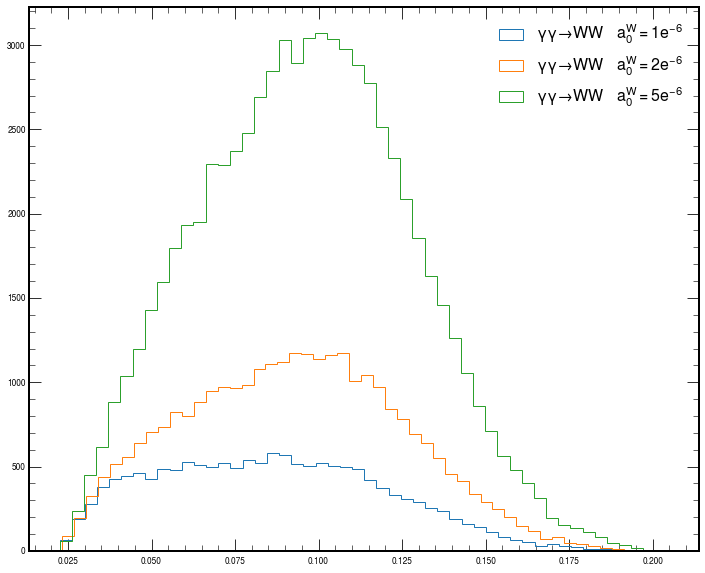

In [6]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Ouf of acceptance protons

In [7]:
# df_signals_protons_multiRP_index_2protons = {}
# df_signals_protons_multiRP_index_1proton_Arm0 = {}
# df_signals_protons_multiRP_index_1proton_Arm1 = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     msk_1proton_Arm0_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) == 0 ) )
#     msk_1proton_Arm1_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     print ( msk_2protons_ )
#     print ( msk_1proton_Arm0_ )
#     print ( msk_1proton_Arm1_ )
#     df_signals_protons_multiRP_index_2protons[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_2protons_ ]
#     df_signals_protons_multiRP_index_1proton_Arm0[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm0_ ]
#     df_signals_protons_multiRP_index_1proton_Arm1[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm1_ ]

In [8]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index_2protons[ label_ ]

In [9]:
# df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]

In [10]:
# df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]

In [11]:
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_2protons
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm0
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm1
# fig = plt.figure( figsize=(12,10) )
# for label_ in labels_signals: 
#     plt.hist( df_signals_protons_multiRP_index_[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
# plt.legend( loc='best', fontsize=16 )

### Signal with mixed protons

In [12]:
# run_tables = True

labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6", "GGToWW-AQGC-mix_protons-A0W2e-6", "GGToWW-AQGC-mix_protons-A0W5e-6" ]

fileNames_signals = {
    "GGToWW-AQGC-mix_protons-A0W1e-6": [ "output-GGToWW-AQGC-mix_protons-A0W1e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W2e-6": [ "output-GGToWW-AQGC-mix_protons-A0W2e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W5e-6": [ "output-GGToWW-AQGC-mix_protons-A0W5e-6.h5" ]
    }

df_counts_signals_mix_protons = {}
df_signals_protons_multiRP_mix_protons_index = {}
df_signals_protons_multiRP_mix_protons_events = {}

for label_ in labels_signals_mix_protons:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, mix_protons=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals_mix_protons[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_mix_protons_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_mix_protons_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/07 20:22:40
Total time elapsed: 1
2021/05/07 20:22:41
Total time elapsed: 0
2021/05/07 20:22:41
Total time elapsed: 2


In [13]:
label_signal_to_mix_protons = {
     "GGToWW-AQGC-A0W1e-6" : "GGToWW-AQGC-mix_protons-A0W1e-6",
     "GGToWW-AQGC-A0W2e-6" : "GGToWW-AQGC-mix_protons-A0W2e-6",
     "GGToWW-AQGC-A0W5e-6" : "GGToWW-AQGC-mix_protons-A0W5e-6"
}

In [14]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [15]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = "GGToWW-AQGC-mix_protons-A0W1e-6"

# df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
# df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm0_ = df_sig_2protons_arm0_.index
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
# df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm1_ = df_sig_2protons_arm1_.index

# df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
# index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
# df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
# index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

# df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
# df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm0_ = df_mix_arm0_.index
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
# df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm1_ = df_mix_arm1_.index

In [16]:
# msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
# df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
# df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()

# msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
# msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
# df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()

In [17]:
# msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
# msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
# msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
# msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
# msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
# msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
# msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
# msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm1_ ) )
# print ( np.sum( ~msk_mix_arm0_ ) )
# print ( np.sum( ~msk_mix_arm1_ ) )
# # df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
# # df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]

In [18]:
# msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
# msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
# msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
# df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
# df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
# df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
# df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

In [19]:
# msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
# msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
# df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()

In [20]:
# msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()

In [21]:
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
# df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
# df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_mix_Arm0_Arm1 = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()

In [22]:
# def concatenate_sig_mix( label_, label_mix_protons_ ):
#     df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
#     df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm0_ = df_sig_2protons_arm0_.index
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
#     df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm1_ = df_sig_2protons_arm1_.index

#     df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
#     index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
#     df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
#     index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

#     df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
#     df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm0_ = df_mix_arm0_.index
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
#     df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm1_ = df_mix_arm1_.index
    
#     # 1 proton in Arm 0, mix in Arm 1
#     msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
#     df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
#     msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()
    
#     # 0 protons
#     msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
#     msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
#     msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
#     msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
#     msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
#     msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
#     msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
#     msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_ ) )
#     print ( np.sum( ~msk_mix_arm0_ ) )
#     print ( np.sum( ~msk_mix_arm1_ ) )
#     df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
#     df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]   
#     df_0protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_0protons_, df_mix_arm1_sig_0protons_ ] ).sort_index()
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0

#     # 2 protons, 1 misreconstructed
#     msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
#     msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
#     msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
#     df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
#     df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
#     df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

#     # 1 proton in Arm 0 misreconstructed, mix in Arm 1
#     msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
#     msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1 misreconstructed, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()    
    
#     # 2 protons, both misreconstructed
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
#     df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()
    
#     return ( df_1proton_Arm0_mix_Arm1_,
#              df_1proton_Arm1_mix_Arm0_,
#              df_0protons_mix_Arm0_Arm1_,
#              df_2protons_Arm0_mix_Arm1_,
#              df_2protons_Arm1_mix_Arm0_,
#              df_1proton_Arm0_mix_Arm0_Arm1_,
#              df_1proton_Arm1_mix_Arm1_Arm0_,
#              df_2protons_mix_Arm0_Arm1_
#            )

In [23]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
# df_1proton_Arm0_mix_Arm1_, df_1proton_Arm1_mix_Arm0_, df_0protons_mix_Arm0_Arm1_, df_2protons_Arm0_mix_Arm1_, df_2protons_Arm1_mix_Arm0_, df_1proton_Arm0_mix_Arm0_Arm1_, df_1proton_Arm1_mix_Arm1_Arm0_, df_2protons_mix_Arm0_Arm1_ = concatenate_sig_mix( label_, label_mix_protons_ )

In [24]:
# df_1proton_Arm0_mix_Arm1_
# # df_1proton_Arm0_mix_Arm1_[ [ "eff_proton_all", "eff_multitrack" ] ]

In [25]:
# df_1proton_Arm1_mix_Arm0_
# # df_1proton_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [26]:
# df_0protons_mix_Arm0_Arm1_
# # df_0protons_mix_Arm0_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [27]:
# df_2protons_Arm0_mix_Arm1_
# # df_2protons_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [28]:
# df_2protons_Arm1_mix_Arm0_
# # df_2protons_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [29]:
# df_1proton_Arm0_mix_Arm0_Arm1_

In [30]:
# df_1proton_Arm1_mix_Arm1_Arm0_

In [31]:
# df_2protons_mix_Arm0_Arm1_[ ['crossingAngle', 'crossingAngle_rnd'] ]

In [32]:
# labels_out_acceptance_misreconstructed_ = ( "1proton_Arm0_mix_Arm1", "1proton_Arm1_mix_Arm0", "0protons_mix_Arm0_Arm1",
#                                             "2protons_Arm0_mix_Arm1", "2protons_Arm1_mix_Arm0",
#                                             "1proton_Arm0_mix_Arm0_Arm1", "1proton_Arm1_mix_Arm1_Arm0", "2protons_mix_Arm0_Arm1" )

# df_signals_protons_multiRP_out_acceptance_misreconstructed = {}

# for label_ in labels_signals:
#     print ( label_ )
#     label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
#     df_signals_protons_multiRP_out_acceptance_misreconstructed__ = concatenate_sig_mix( label_, label_mix_protons_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ] = {}
#     for idx_, df__ in enumerate( df_signals_protons_multiRP_out_acceptance_misreconstructed__ ):
#         print ( labels_out_acceptance_misreconstructed_[ idx_ ] )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ labels_out_acceptance_misreconstructed_[ idx_ ] ] = df__

In [33]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]:
#     print ( key_ )
#     df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#     plt.hist( df__[ 'xi' ], histtype='step', bins=50, label=key_ )
# plt.legend( loc='best', fontsize=16 )

In [34]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_index[ label_ ].columns
# columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

# columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
#                   "trackx1", "tracky1", "trackpixshift1", "rpid1",
#                   "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
# columns_drop_eff_ = columns_drop_.copy()
# columns_drop_eff_.extend( columns_eff_ )

# df_signals_protons_multiRP_out_acceptance_misreconstructed_events = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]: 
#         print ( key_ )
#         columns_drop__ = columns_drop_ if key_ in ( '0protons_mix_Arm0_Arm1', '1proton_Arm0_mix_Arm0_Arm1', '1proton_Arm1_mix_Arm1_Arm0', '2protons_mix_Arm0_Arm1' ) else columns_drop_eff_
#         df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#         df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ] = df_protons_multiRP_events__

### Signal with event mixing

In [35]:
df_signals_protons_multiRP_eff_sel_index = {}
df_signals_protons_multiRP_sig_plus_mix_index = {}

np.random.seed( 12345 )

for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero_weighted" ] = 1.0
    
    msk_eff_proton_ = np.random.rand( df_signals_protons_multiRP_index[ label_ ].shape[0] ) < df_signals_protons_multiRP_index[ label_ ].loc[ :, "eff_proton_all" ]
    print ( msk_eff_proton_ )
    df_signals_protons_multiRP_eff_sel_index[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_eff_proton_ ]

#     df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
#         [ df_signals_protons_multiRP_index[ label_ ],
#           df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()
    df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
        [ df_signals_protons_multiRP_eff_sel_index[ label_ ],
          df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2266       226549  0        False
                226551  0         True
                        0         True
     2267       226605  0         True
                226690  0        False
     2268       226716  0         True
                226773  0        False
     2270       226932  0        False
                        0        False
     2273       227227  0         True
                        0         True
     2274       227321  0        False
                227328  0         True
                227324  0         True
     2275       227457  0        False
                        0         True
     2276       227546  0        False
                        0        False
                227579  0        False
                        0         True
     2277       227611  0         True
                227610  0        False
                227661  0         True
     2278       227745  0        False
     2279     

<ipython-input-35-6595e51fab37>:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(


GGToWW-AQGC-A0W2e-6
run  lumiblock  event   slice
1    1729       172817  0         True
                172837  0         True
                172844  0         True
     1730       172907  0        False
                        0        False
                172923  0        False
                172921  0         True
                        0        False
                172940  0         True
                        0         True
                172948  0         True
                173000  0        False
     1731       173003  0        False
                173072  0         True
                173091  0        False
                        0         True
     1732       173113  0         True
                        0         True
                173135  0         True
                173156  0         True
                173187  0        False
                        0         True
                173198  0        False
                        0        False
     1733     

In [36]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_index[ label_ ]

crossingAngle        xi       thx       thy  \
run lumiblock event  slice                                                
1   2266      226549 0              120.0  0.049396  0.000070  0.000006   
              226551 0              120.0  0.047449  0.000007  0.000021   
                     0              120.0  0.051457  0.000022  0.000089   
    2267      226605 0              120.0  0.129090  0.000042 -0.000010   
              226690 0              120.0  0.028568  0.000061 -0.000014   
    2268      226716 0              150.0  0.164051 -0.000072 -0.000019   
              226773 0              150.0  0.044415 -0.000016  0.000041   
    2270      226932 0              130.0  0.032306  0.000006 -0.000075   
                     0              130.0  0.119526 -0.000012  0.000005   
    2273      227227 0              130.0  0.056667 -0.000025 -0.000072   
                     0              130.0  0.053138 -0.000011 -0.000024   
    2274      227321 0              150.0  0.082597  0.000042 -0.000018   
              227328 0              150.0  0.141799 -0.000062  0.000005   
              227324 0              150.0  0.057238 -0.000019  0.000045   
    2275      227457 0              150.0  0.068920 -0.000051  0.000024   
                     0              150.0  0.115064  0.000022  0.000018   
    2276      227546 0              140.0  0.090561 -0.000041  0.000076   
                     0              140.0  0.125299 -0.000021  0.000054   
              227579 0              140.0  0.118551 -0.000022 -0.000012   
                     0              140.0  0.169634 -0.000121 -0.000032   
    2277      227611 0              130.0  0.037509  0.000041  0.000004   
              227610 0              130.0  0.088627 -0.000125 -0.000004   
              227661 0              130.0  0.057884  0.000036  0.000051   
    2278      227745 0              150.0  0.084094 -0.000080 -0.000087   
    2279      227825 0              130.0  0.067304 -0.000003  0.000013   
              227868 0              130.0  0.062334  0.000017  0.000011   
    2280      227969 0              120.0  0.085506  0.000025  0.000011   
    2282      228117 0              130.0  0.037401  0.000059  0.000036   
                     0              130.0  0.058293  0.000015  0.000080   
              228121 0              130.0  0.100883 -0.000009 -0.000044   
...                                   ...       ...       ...       ...   
    9019      401833 0              130.0  0.128527 -0.000033 -0.000013   
              401874 0              130.0  0.033579 -0.000103 -0.000091   
                     0              130.0  0.084197  0.000007  0.000073   
    9021      402066 0              119.0  0.036611  0.000072  0.000042   
                     0              119.0  0.046874  0.000018  0.000021   
              402070 0              119.0  0.042629  0.000002  0.000039   
              402092 0              119.0  0.102647 -0.000046  0.000074   
    9024      402306 0              150.0  0.101640  0.000058  0.000090   
              402311 0              150.0  0.108578 -0.000074  0.000040   
              402331 0              150.0  0.107441  0.000044  0.000004   
              402381 0              150.0  0.100368 -0.000052 -0.000037   
    9026      402504 0              150.0  0.041278  0.000096 -0.000116   
    9039      403821 0              130.0  0.102213  0.000027  0.000032   
    9041      404017 0              130.0  0.057910 -0.000056 -0.000008   
              404092 0              130.0  0.075079  0.000072 -0.000071   
              404091 0              130.0  0.132769 -0.000061  0.000051   
    9042      404200 0              140.0  0.089057  0.000003  0.000123   
    9043      404249 0              140.0  0.099805  0.000084  0.000034   
    9049      404804 0              120.0  0.086237  0.000060  0.000043   
              404867 0              120.0  0.117212 -0.000054  0.000115   
              404859 0              120.0  0.069489 -

In [37]:
df_signals_protons_multiRP_eff_sel_index[ label_ ]

crossingAngle        xi       thx       thy  \
run lumiblock event  slice                                                
1   2266      226551 0              120.0  0.047449  0.000007  0.000021   
                     0              120.0  0.051457  0.000022  0.000089   
    2267      226605 0              120.0  0.129090  0.000042 -0.000010   
    2268      226716 0              150.0  0.164051 -0.000072 -0.000019   
    2273      227227 0              130.0  0.056667 -0.000025 -0.000072   
                     0              130.0  0.053138 -0.000011 -0.000024   
    2274      227328 0              150.0  0.141799 -0.000062  0.000005   
              227324 0              150.0  0.057238 -0.000019  0.000045   
    2275      227457 0              150.0  0.115064  0.000022  0.000018   
    2276      227579 0              140.0  0.169634 -0.000121 -0.000032   
    2277      227611 0              130.0  0.037509  0.000041  0.000004   
              227661 0              130.0  0.057884  0.000036  0.000051   
    2279      227825 0              130.0  0.067304 -0.000003  0.000013   
              227868 0              130.0  0.062334  0.000017  0.000011   
    2282      228117 0              130.0  0.037401  0.000059  0.000036   
                     0              130.0  0.058293  0.000015  0.000080   
              228121 0              130.0  0.100883 -0.000009 -0.000044   
              228194 0              130.0  0.075288  0.000121  0.000027   
    2284      228336 0              120.0  0.093651 -0.000024 -0.000081   
              228335 0              120.0  0.129740  0.000070  0.000082   
    2286      228503 0              130.0  0.097616 -0.000020  0.000064   
                     0              130.0  0.106465  0.000008  0.000020   
              228565 0              130.0  0.088063 -0.000030  0.000009   
    2291      229042 0              140.0  0.030846 -0.000036 -0.000067   
                     0              140.0  0.079514 -0.000010  0.000093   
    2292      229140 0              130.0  0.100346  0.000049 -0.000080   
              229152 0              130.0  0.051193 -0.000037  0.000006   
    2294      229378 0              120.0  0.108844  0.000036  0.000069   
    2296      229519 0              120.0  0.088692 -0.000066 -0.000067   
              229520 0              120.0  0.076609 -0.000050  0.000007   
...                                   ...       ...       ...       ...   
    6553      155203 0              130.0  0.101202 -0.000006  0.000054   
    6554      155360 0              120.0  0.105238  0.000041  0.000070   
    6556      155581 0              150.0  0.095447 -0.000004 -0.000073   
    9088      408769 0              120.0  0.106919  0.000033  0.000007   
    9014      401359 0              120.0  0.085208  0.000047  0.000016   
    9015      401489 0              120.0  0.139251  0.000014  0.000003   
              401494 0              120.0  0.066395 -0.000090 -0.000097   
    9016      401522 0              150.0  0.154806 -0.000110 -0.000005   
              401525 0              150.0  0.061208  0.000031  0.000032   
    9017      401681 0              120.0  0.075163  0.000018  0.000003   
    9018      401784 0              130.0  0.117140  0.000047  0.000065   
    9019      401874 0              130.0  0.033579 -0.000103 -0.000091   
                     0              130.0  0.084197  0.000007  0.000073   
    9021      402066 0              119.0  0.046874  0.000018  0.000021   
    9024      402306 0              150.0  0.101640  0.000058  0.000090   
              402331 0              150.0  0.107441  0.000044  0.000004   
              402381 0              150.0  0.100368 -0.000052 -0.000037   
    9039      403821 0              130.0  0.102213  0.000027  0.000032   
    9041      404017 0              130.0  0.057910 -0.000056 -0.000008   
              404091 0              130.0  0.132769 -0.000061  0.000051   
    9043      404249 0              140.0  0.099805  

In [38]:
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [39]:
# df_signals_protons_multiRP_sig_plus_mix_index[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   2         190    0      305965       NaN  2017F3          130.0   
    3         256    0      305965       NaN  2017F3          130.0   
              292    0      305178       NaN  2017F2          130.0   
                     0      305178  305313.0  2017F2          130.0   
    4         330    0      302030       NaN   2017D          130.0   
    5         475    0      299337       NaN  2017C1          150.0   
                     0      299337  300515.0  2017C1          150.0   
    6         548    0      303435  304292.0   2017E          130.0   
              555    0      303435  304333.0   2017E          130.0   
              576    0      305178       NaN  2017F2          130.0   
    7         661    0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
              700    0      299337       NaN  2017C1          130.0   
                     0      299337  300157.0  2017C1          130.0   
    8         719    0      297020       NaN   2017B          130.0   
    10        909    0      303435  304170.0   2017E          150.0   
              973    0      305965       NaN  2017F3          150.0   
    12        1121   0      305178       NaN  2017F2          130.0   
              1141   0      299337  300560.0  2017C1          130.0   
    13        1220   0      305178       NaN  2017F2          150.0   
                     0      305178  305204.0  2017F2          150.0   
    15        1413   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
              1467   0      305965       NaN  2017F3          150.0   
    16        1519   0      297020       NaN   2017B          120.0   
    17        1636   0      303435       NaN   2017E          140.0   
                     0      303435  304663.0   2017E          140.0   
              1668   0      304911       NaN  2017F1          140.0   
    19        1810   0      302030       NaN   2017D          120.0   
    20        1948   0      305965       NaN  2017F3          150.0   
...                            ...       ...     ...            ...   
    9977      497640 0      305965       NaN  2017F3          140.0   
                     0      305965  306125.0  2017F3          140.0   
    9979      497802 0      300806       NaN  2017C2          130.0   
                     0      300806  301330.0  2017C2          130.0   
              497875 0      303435  303832.0   2017E          130.0   
    9981      498038 0      305178       NaN  2017F2          120.0   
                     0      305178  305862.0  2017F2          120.0   
    9982      498159 0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    9983      498202 0      305178       NaN  2017F2          120.0   
                     0      305178  305365.0  2017F2          120.0   
              498238 0      303435       NaN   2017E          120.0   
    9984      498309 0      303435       NaN   2017E          130.0   
              498324 0      300806       NaN  2017C2          130.0   
    9985      498456 0      302030       NaN   2017D          120.0   
              498476 0      297020       NaN   2017B          120.0   
                     0      297020  297114.0   2017B          120.0   
    9986      498533 0      304911  305081.0  2017F1          150.0   
    9987      498657 0      303435       NaN   2017E          130.0   
    9991      499041 0      300806       NaN  2017C2          130.0   
              499091 0      303435       NaN   2017E          130.0   
    9993      499237 0      305178  305405.0  2017F2          150.0   
    9994      499358 0      305965  306092.0  2017F3          150.0   
    9995      499414 0      302030       NaN   2017D

In [40]:
df_signals_protons_multiRP_sig_plus_mix_2protons = {}
for label_ in labels_signals:
    print ( label_ )
    df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_2protons_single_proton_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) & ( np.sum( s_ == 1 ) == 1 ) )
    print ( msk_2protons_single_proton_, np.sum( msk_2protons_single_proton_ ) )
    df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ] = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].loc[ msk_2protons_single_proton_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2          190     0        False
     3          256     0        False
                292     0        False
                        0        False
     4          330     0        False
     5          475     0        False
                        0        False
     6          548     0        False
                555     0        False
                576     0        False
     7          661     0         True
                        0         True
                700     0        False
                        0        False
     8          719     0        False
     10         909     0        False
                973     0        False
     12         1121    0        False
                1141    0        False
     13         1220    0         True
                        0         True
     15         1413    0         True
                        0         True
                1467    0        False
     16       

In [41]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   7         661    0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
    13        1220   0      305178       NaN  2017F2          150.0   
                     0      305178  305204.0  2017F2          150.0   
    15        1413   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    29        2846   0      305178       NaN  2017F2          150.0   
                     0      305178  305814.0  2017F2          150.0   
    34        3364   0      300806       NaN  2017C2          150.0   
                     0      300806  301997.0  2017C2          150.0   
    39        3832   0      305178       NaN  2017F2          130.0   
                     0      305178  305406.0  2017F2          130.0   
    45        4462   0      297020       NaN   2017B          150.0   
                     0      297020       NaN   2017B          150.0   
    47        4636   0      305178       NaN  2017F2          130.0   
                     0      305178  305364.0  2017F2          130.0   
    50        4970   0      303435       NaN   2017E          120.0   
                     0      303435  304738.0   2017E          120.0   
    52        5147   0      302030  302228.0   2017D          130.0   
                     0      302030  302228.0   2017D          130.0   
    54        5302   0      305178       NaN  2017F2          120.0   
                     0      305178       NaN  2017F2          120.0   
    72        7117   0      299337  299593.0  2017C1          150.0   
                     0      299337  299593.0  2017C1          150.0   
    78        7721   0      303435  304777.0   2017E          140.0   
                     0      303435  304777.0   2017E          140.0   
    81        8018   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    93        9298   0      302030       NaN   2017D          120.0   
                     0      302030  302573.0   2017D          120.0   
...                            ...       ...     ...            ...   
    9922      492154 0      300806       NaN  2017C2          120.0   
                     0      300806       NaN  2017C2          120.0   
    9928      492715 0      305178       NaN  2017F2          140.0   
                     0      305178       NaN  2017F2          140.0   
    9937      493601 0      302030       NaN   2017D          120.0   
                     0      302030  302572.0   2017D          120.0   
    9942      494129 0      297020       NaN   2017B          150.0   
                     0      297020       NaN   2017B          150.0   
    9950      494979 0      305965       NaN  2017F3          150.0   
                     0      305965  306459.0  2017F3          150.0   
    9956      495568 0      300806       NaN  2017C2          120.0   
                     0      300806  301665.0  2017C2          120.0   
    9965      496415 0      304911       NaN  2017F1          120.0   
                     0      304911  305045.0  2017F1          120.0   
    9966      496511 0      304911       NaN  2017F1          140.0   
                     0      304911  305112.0  2017F1          140.0   
    9968      496707 0      305178  305252.0  2017F2          150.0   
                     0      305178  305252.0  2017F2          150.0   
    9970      496950 0      300806       NaN  2017C2          150.0   
                     0      300806       NaN  2017C2          150.0   
    9977      497640 0      305965       NaN  2017F3          140.0   
                     0      305965  306125.0  2017F3          140.0   
    9979      497802 0      300806       NaN  2017C2          130.0   
                     0      300806  301330.0  2017C2

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_2protons_sig = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0 = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1 = {}
df_signals_protons_multiRP_sig_plus_mix_2protons_mix = {}
for label_ in labels_signals:
    print ( label_ )
#     df_protons_multiRP_groupby_random_ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ "random" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 2 ) )
#     msk_1proton_sig_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) )
#     msk_2protons_mix_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) )
#     print ( msk_2protons_, np.sum( msk_2protons_ ) )
#     print ( msk_1proton_sig_, np.sum( msk_1proton_sig_ ) )
#     print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_groupby__ = df__[ [ "arm", "random" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_sig_Arm0_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 0 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_sig_Arm1_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 1 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_2protons_ = ( msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_1proton_sig_Arm0_ = ( msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    msk_1proton_sig_Arm1_ = ( ~msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_2protons_mix_ = ( ~msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    print ( msk_2protons_, np.sum( msk_2protons_ ) )
    print ( msk_1proton_sig_Arm0_, np.sum( msk_1proton_sig_Arm0_ ) )
    print ( msk_1proton_sig_Arm1_, np.sum( msk_1proton_sig_Arm1_ ) )
    print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ] = df__.loc[ msk_2protons_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ] = df__.loc[ msk_1proton_sig_Arm0_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ] = df__.loc[ msk_1proton_sig_Arm1_ ]
    df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ] = df__.loc[ msk_2protons_mix_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    7          661     0         True
     13         1220    0        False
     15         1413    0         True
     29         2846    0        False
     34         3364    0        False
     39         3832    0        False
     45         4462    0         True
     47         4636    0        False
     50         4970    0        False
     52         5147    0        False
     54         5302    0         True
     72         7117    0        False
     78         7721    0        False
     81         8018    0         True
     93         9298    0        False
     98         9713    0        False
                9730    0         True
     103        10231   0        False
     105        10427   0        False
     109        10818   0         True
     113        11246   0        False
     114        11390   0        False
     118        11748   0         True
     121        12011   0         True
     129      

run  lumiblock  event   slice
1    3          204     0         True
     9          835     0        False
                862     0         True
     13         1269    0         True
     15         1470    0        False
     18         1767    0        False
                1779    0        False
     20         2000    0        False
     22         2108    0        False
     23         2259    0        False
     25         2403    0        False
                2423    0         True
     27         2643    0         True
     33         3233    0        False
                3242    0         True
     35         3425    0        False
                3492    0        False
     38         3720    0         True
     44         4363    0         True
     49         4896    0         True
     51         5047    0         True
     52         5151    0        False
     53         5300    0         True
     54         5400    0         True
     56         5587    0        F

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
columns_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].columns
columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
                  "trackx1", "tracky1", "trackpixshift1", "rpid1",
                  "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
columns_drop_eff_ = columns_drop_.copy()
columns_drop_eff_.extend( columns_eff_ )

df_signals_protons_multiRP_sig_plus_mix_2protons_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events = {}
df_signals_protons_multiRP_sig_plus_mix_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = df_protons_multiRP_events__
    
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ] = df_protons_multiRP_events__

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ]

### Select events

In [ ]:
selection_keys_signals = {}
selections_signals = {}
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ], selection_keys_signals[ label_ ], selections_signals[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

In [ ]:
print ( selection_keys_signals )
print ( selections_signals )

In [ ]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events = {}
# for label_ in labels_signals:
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ]: 
#         print ( key_ )
#         df_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ]
#         print ( df_events__.shape[0] )
#         df_selected_events__, selection_keys__, selections__ = select_events( df_events__ )
#         print ( df_selected_events__.shape[0] )
#         print ( selection_keys__ )
#         print ( selections__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ] = df_selected_events__

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_selected_events = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    df_events__ = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ] = df_selected_events__
    
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
        print ( key_ )
        df_events__ = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]
        print ( df_events__.shape[0] )
        df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
        print ( df_selected_events__.shape[0] )
        print ( selection_keys__ )
        print ( selections__ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ] = df_selected_events__

In [ ]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

In [ ]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( key_ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( key_ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_

In [ ]:
label_ = "GGToWW-AQGC-A0W1e-6"

print ( df_signals_protons_multiRP_events[ label_ ].columns )
df_signals_protons_multiRP_events[ label_ ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ '2protons_sig' ]

In [ ]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

weights_mc = {}
weights_sig_plus_mix_2protons = {}
weights_sig_plus_mix_categories = {}
# weights_out_acceptance_misreconstructed = {}
for label_ in labels_signals:
    print ( label_ )
    
    weights_mc[ label_ ] = ( df_signals_protons_multiRP_events[ label_ ][ "norm" ] * 
                             df_signals_protons_multiRP_events[ label_ ][ "pileupWeight" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "sf_muon_id" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_proton_all" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_multitrack" ] )
    
#     weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_proton_all" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
    weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
    
    weights_sig_plus_mix_categories[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( key_ )
        df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
#         weights_sig_plus_mix_categories[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
#                                                               df_selected_events__[ "pileupWeight" ] *
#                                                               df_selected_events__[ "sf_muon_id" ] *
#                                                               df_selected_events__[ "eff_proton_all" ] *
#                                                               df_selected_events__[ "eff_strictzero" ] )
        weights_sig_plus_mix_categories[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
                                                              df_selected_events__[ "pileupWeight" ] *
                                                              df_selected_events__[ "sf_muon_id" ] *
                                                              df_selected_events__[ "eff_strictzero" ] )
    
#     weights_out_acceptance_misreconstructed[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( key_ )
#         df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#         weights_out_acceptance_misreconstructed[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
#                                                                       df_selected_events__[ "pileupWeight" ] *
#                                                                       df_selected_events__[ "sf_muon_id" ] *
#                                                                       df_selected_events__[ "eff_proton_all" ] *
#                                                                       df_selected_events__[ "eff_multitrack" ] )
        
print ( weights_mc )
print ( weights_sig_plus_mix_2protons )
print ( weights_sig_plus_mix_categories )
# print ( weights_out_acceptance_misreconstructed )

In [ ]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat = {}
weights_sig_plus_mix_categories_concat = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig = {}
weights_sig_plus_mix_categories_concat_skip_sig = {}
for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] )
    weights_sig_plus_mix_categories_concat[ label_ ] = pd.concat( weights_sig_plus_mix_categories[ label_ ] )
    print ( weights_sig_plus_mix_categories_concat[ label_ ] )
    
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ = {}
    weights_sig_plus_mix_categories__ = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        if key_ == '2protons_sig': continue
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ key_ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
        weights_sig_plus_mix_categories__[ key_ ] = weights_sig_plus_mix_categories[ label_ ][ key_ ]
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ )
    weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] = pd.concat( weights_sig_plus_mix_categories__ )
    print ( weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] )

In [ ]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat = {}
# weights_out_acceptance_misreconstructed_concat = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )
#     print ( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ].shape[0] )
#     weights_out_acceptance_misreconstructed_concat[ label_ ] = pd.concat( weights_out_acceptance_misreconstructed[ label_ ] )
#     print ( weights_out_acceptance_misreconstructed_concat[ label_ ] )

### Plot signal

In [ ]:
# label_ = "GGToWW-AQGC-A0W5e-6"

# fig = plt.figure( figsize=(10,8) )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaEta_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaR_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_met" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_Wlep" ], bins=100 )

# # plt.yscale( 'log' )

In [ ]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

In [ ]:
label_ = "GGToWW-AQGC-A0W5e-6"
# label_WW_ = "_nom"
label_WW_ = "_jes_up"

fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "R_MWW_MX" + label_WW_ ], weights=weights_sig_plus_mix_2protons[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=30, range=(0.,3.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ "R_MWW_MX" + label_WW_ ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.png", bbox_inches='tight' )

In [ ]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "R_MWW_MX" + label_WW_ ], weights=weights_sig_plus_mix_categories[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( (0.,3.) )

In [ ]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "Diff_YWW_YX" + label_WW_ ], weights=weights_sig_plus_mix_categories[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( (0.,3.) )

In [ ]:
# label_ = "GGToWW-AQGC-A0W5e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#     print ( key_ )
#     df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#     plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_out_acceptance_misreconstructed[ label_ ][ key_ ],
#               histtype='step', label=key_,
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )

In [ ]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=30, range=(0.,3.) )
#     plt.hist( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ][ "ratioMWW_MX" ],
#               weights=weights_out_acceptance_misreconstructed_concat[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
#               bins=30, range=(0.,3.) )


# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )